In [73]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from dotenv import dotenv_values
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

config = dotenv_values(".env")

In [42]:
#!pip install wordcloud

In [35]:
bearer_token = config["BEARER_TOKEN"]

search_url = "https://api.twitter.com/2/tweets/search/recent" #if you want to change this you can look in the documentation 

#this needs to look like a json object so it looks like a python dictionary 
query_params = {
    'query' : "\"Cattle\" -is:retweet", 
    'max_results' : '100',
    'tweet.fields': 'author_id', 
}

#this is going to set our quest so they know we have authorization and where we are coming from
def bearer_oauth(r):
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2RecentSearchPython"
    return r

#This is a http request. This is how we access their API. This is how we send a request to a specific website. 
def connect_to_endpoint(url, params):
    response = requests.get(url, auth=bearer_oauth, params=params)
   
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

# Querying the API
json_response = connect_to_endpoint(search_url, query_params)

# Parsing the response
parsedRes = json.dumps(json_response, indent=4, sort_keys=True, ensure_ascii=True) #ensure_ascii=False so non latin charaters and emojis wont so up
print(parsedRes)

200
{
    "data": [
        {
            "author_id": "9019142",
            "edit_history_tweet_ids": [
                "1609327794000912386"
            ],
            "id": "1609327794000912386",
            "text": "CHINA AND CANADA BEEF: China still barring Canadian bovine - #news #canada #china #beef #politics #government #cdnpoli #cdnpolitics #trudeau #justintrudeau #agriculture #agribusiness #animals #foodprices #cattle #ranch #ranchers #ranching #CPC #LPC https://t.co/o3EdqtIgNp"
        },
        {
            "author_id": "1573610674537857025",
            "edit_history_tweet_ids": [
                "1609327777877983236"
            ],
            "id": "1609327777877983236",
            "text": "#OpIran #Mahsa_Amini \n@EIA_News \nThe dangerous and non-standard mining practices in Kurdistan region of #Iran has poluted people's drinking water with #Arsenic. People and their cattle are falling ill as the result. https://t.co/2LQhanNt8G"
        },
        {
            "auth

In [4]:
# similar as above just more detailed
import csv

# Extract the data from the response
data = json_response['data']

# Open a file for writing
with open('tweets.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer
    writer = csv.writer(csvfile)
    
    # Write the header row
    writer.writerow(['Author ID', 'Tweet ID', 'Tweet Text'])
    
    # Write the data rows
    for tweet in data:
        author_id = tweet['author_id']
        tweet_id = tweet['id']
                         
# Extract the data from the response
data = json_response['data']

# Open a file for writing
with open('tweets.csv', 'w', newline='', encoding='utf-8') as csvfile:
    # Create a CSV writer
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Author ID', 'Tweet ID', 'Tweet Text'])

    # Write the data rows
    for tweet in data:
        author_id = tweet['author_id']
        tweet_id = tweet['id']
        if 'text' in tweet:
            tweet_text = tweet['text']
        else:
            tweet_text = ''
        writer.writerow([author_id, tweet_id, tweet_text])

In [33]:
# Attempt to get more tweets

# Set the initial value of next_token to None
next_token = None

# Set the maximum number of pages to retrieve
max_pages = 10

# Set the maximum number of tweets per page
page_size = 100

# Initialize an empty list to store the tweets
tweets = []

# Keep making requests to the API until we have retrieved the maximum number of pages or until the next_token is not present in the response
for i in range(max_pages):
    # Set the query parameters for the current page
    query_params = {
        'query' : "\"Cattle\" -is:retweet", 
        'max_results' : str(page_size),
        'tweet.fields': 'author_id', 
        'start_time': next_token
    }
    
    # Make a request to the API
    json_response = connect_to_endpoint(search_url, query_params)
    
    # Get the next_token from the response
    next_token = json_response.get('next_token')
    
    # If there is no next_token, we have reached the last page of results
    if next_token is None:
        break
    
    # Extract the tweets from the response
    page_tweets = json_response['data']
    
    # Add the tweets to the list of all tweets
    tweets.extend(page_tweets)

# Print the total number of tweets retrieved
print(f'Total number of tweets retrieved: {len(tweets)}')


200
Total number of tweets retrieved: 0


In [8]:
import csv
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')


# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Open the CSV file for reading
with open('tweets.csv', 'r', encoding='utf-8') as csvfile:
    # Create a CSV reader
    reader = csv.reader(csvfile)

    # Skip the header row
    next(reader)

    # Create an empty list to store the tweet data
    data = []
    
    # Iterate through the rows of the CSV file
    for row in reader:
        # Extract the tweet text
        tweet_text = row[2]

        # Use the SentimentIntensityAnalyzer to get the sentiment scores for the tweet
        scores = sia.polarity_scores(tweet_text)

         # Determine the polarity rating based on the compound score
        if scores['compound'] > 0:
            polarity_rating = 'Positive'
        elif scores['compound'] < 0:
            polarity_rating = 'Negative'
        else:
            polarity_rating = 'Neutral'

        # Add the tweet data and polarity rating to the list
        data.append([row[0], row[1], tweet_text, scores['compound'], polarity_rating])

        # Create a dataframe from the list of tweet data
        df = pd.DataFrame(data, columns=['Username', 'Date', 'Tweet', 'Compound Score', 'Polarity Rating'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\naomi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


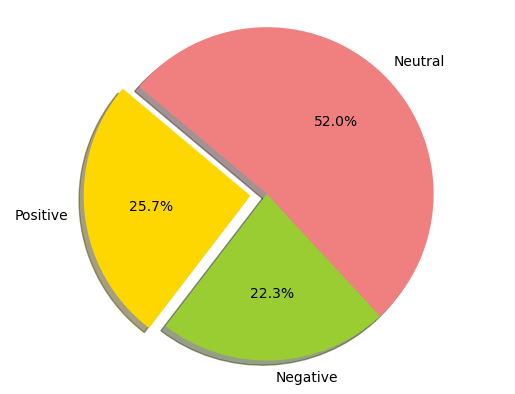

In [38]:
# need to amend to my analysis
#Plotting sentiments
labels = 'Positive', 'Negative', 'Neutral'
sizes = [257, 223, 520]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [9]:
df.shape

(100, 5)

In [10]:
df.head()

,Username,Date,Tweet,Compound Score,Polarity Rating
0,353731746,1609322475875188737,Just wait until you see beef prices this sprin...,-0.0258,Negative
1,3358618452,1609322379326509059,@whatadina Cattle exhibition hai :p,0.3400,Positive
2,823346831576989698,1609322368517668868,@yashar Having land does not mean you can take...,0.0000,Neutral
3,1889436434,1609322080360890368,@realJohnKempf The meat packing industry is th...,-0.4215,Negative
4,1465533723508621313,1609321944486416385,"@Longhorns_B12C Oh no, that smell is bc some c...",-0.2960,Negative


In [18]:
# Cleaning Data
# Removing @ handle
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
     
    return input_txt 

df['Tweet'] = np.vectorize(remove_pattern)(df['Tweet'], "@[\w]*")

df.head()

,Username,Date,Tweet,Compound Score,Polarity Rating
0,353731746,1609322475875188737,Just wait until you see beef prices this sprin...,-0.0258,Negative
1,3358618452,1609322379326509059,Cattle exhibition hai :p,0.3400,Positive
2,823346831576989698,1609322368517668868,Having land does not mean you can take a big ...,0.0000,Neutral
3,1889436434,1609322080360890368,The meat packing industry is the biggest hurd...,-0.4215,Negative
4,1465533723508621313,1609321944486416385,"Oh no, that smell is bc some cattle from down...",-0.2960,Negative


In [19]:
df['Tweet'].head()

0    Just wait until you see beef prices this sprin...
1                             Cattle exhibition hai :p
2     Having land does not mean you can take a big ...
3     The meat packing industry is the biggest hurd...
4     Oh no, that smell is bc some cattle from down...
Name: Tweet, dtype: object

In [39]:
#Cleaning Tweets
corpus = []
for i in range(0, 100):
    tweet = re.sub('[^a-zA-Z0-9]', ' ', df['Tweet'][i])
    tweet = tweet.lower()
    tweet = re.sub('rt', '', tweet)
    tweet = re.sub('http', '', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = tweet.split()
    ps = PorterStemmer()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

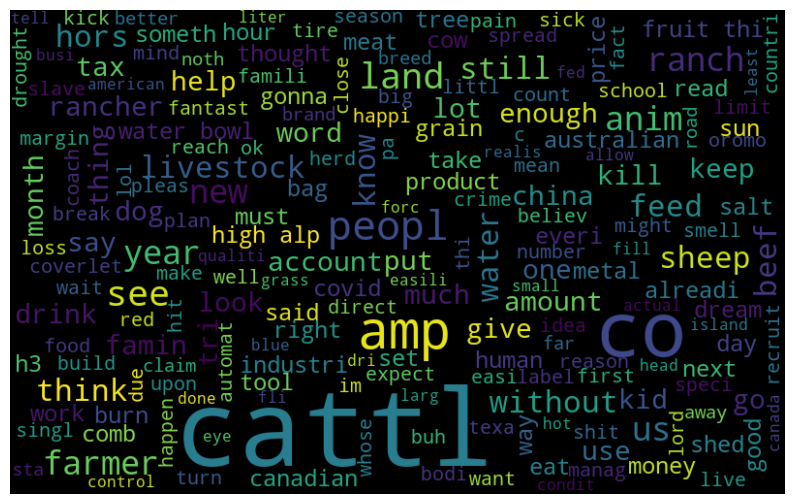

In [44]:
#Visualization
#Word Cloud
all_words = ' '.join([text for text in corpus])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [48]:
#Term Freuency - TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['Tweet'])
#Count Most Frequent Words
Counter = Counter(corpus)
most_occur = Counter.most_common(10) 
print(most_occur)

[('13 million affect famin oromia ethiopian gov amp terrorist amhara fano complic famin burn oromo farmer crop loot propei amp cattl wob saveoromol', 2), ('wait see beef price spring gonna pretti cattl feed lot due drought gonna get ugli co sspjexvvaa', 1), ('cattl exhibit hai p', 1), ('land mean take big financi hit rais beef cattl close 1000 acr land spend lot money tri keep everyth go slim margin surviv', 1), ('meat pack industri biggest hurdl consist suppli finish cattl tricki demonstr issu abl address reason advoc', 1), ('oh smell bc cattl south town', 1), ('santa fe cattl co broken arrow ok co wdj0wu01wt', 1), ('hope cattl price hold', 1), ('read alreadi sapien trash harari psychopath brag wef event use technolog turn goyim slave cattl murder useless human idea paraphras torah', 1), ('realli consid season month day hour number tool song cattl hors amp bodi pa anim tool food plant tree peopl cloth holiday build local geographi weather name be amp thing peopl must word amp c', 1)]


In [49]:
df

,Username,Date,Tweet,Compound Score,Polarity Rating
0,353731746,1609322475875188737,Just wait until you see beef prices this sprin...,-0.0258,Negative
1,3358618452,1609322379326509059,Cattle exhibition hai :p,0.3400,Positive
2,823346831576989698,1609322368517668868,Having land does not mean you can take a big ...,0.0000,Neutral
3,1889436434,1609322080360890368,The meat packing industry is the biggest hurd...,-0.4215,Negative
4,1465533723508621313,1609321944486416385,"Oh no, that smell is bc some cattle from down...",-0.2960,Negative
...,...,...,...,...,...
95,1598999099579469825,1609310726119903233,and heads and mouths of cattle. ...,0.0000,Neutral
96,1541797602265468928,1609310725637541888,And they'd find us in a week when the cattle s...,-0.4939,Negative
97,64954849,1609310437404729349,19/ The implication of this move is profound. ...,0.0000,Neutral
98,64954849,1609310433864814593,"17/ Metals embody some other inherent quality,...",0.0000,Neutral


In [55]:
df = df.drop(columns=['Username', 'Date', 'Compound Score'])

In [54]:
df

,Tweet,Compound Score,Polarity Rating
0,Just wait until you see beef prices this sprin...,-0.0258,Negative
1,Cattle exhibition hai :p,0.3400,Positive
2,Having land does not mean you can take a big ...,0.0000,Neutral
3,The meat packing industry is the biggest hurd...,-0.4215,Negative
4,"Oh no, that smell is bc some cattle from down...",-0.2960,Negative
...,...,...,...
95,and heads and mouths of cattle. ...,0.0000,Neutral
96,And they'd find us in a week when the cattle s...,-0.4939,Negative
97,19/ The implication of this move is profound. ...,0.0000,Neutral
98,"17/ Metals embody some other inherent quality,...",0.0000,Neutral


In [56]:
one_hot = pd.get_dummies(df["Polarity Rating"])
df.drop(['Polarity Rating'],axis=1,inplace=True)
df = pd.concat([df,one_hot],axis=1)
df.head()

,Tweet,Compound Score,Negative,Neutral,Positive
0,Just wait until you see beef prices this sprin...,-0.0258,1,0,0
1,Cattle exhibition hai :p,0.3400,0,0,1
2,Having land does not mean you can take a big ...,0.0000,0,1,0
3,The meat packing industry is the biggest hurd...,-0.4215,1,0,0
4,"Oh no, that smell is bc some cattle from down...",-0.2960,1,0,0


In [59]:
X = df['Tweet'].values
y = df.drop('Tweet', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [63]:
vect = CountVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [64]:
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [71]:
model = Sequential()

model.add(Dense(units=12673,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=4000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=3, activation='softmax'))

opt=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [75]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x=X_train, y=y_train, batch_size=256, epochs=100, validation_data=(X_test, y_test), verbose=1, 
          callbacks=early_stop)

Epoch 1/100


ValueError: in user code:

    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\naomi\anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 4) and (None, 3) are incompatible


It looks like you are trying to fit a model and encountering a ValueError with the message "Shapes (None, 4) and (None, 3) are incompatible". This error is usually caused by a mismatch between the shapes of the training data and the model's input shape.

To fix this error, you need to make sure that the shapes of the training data (X_train and y_train) and the model's input shape are compatible. The first dimension of the training data should match the model's input shape, and the second dimension should match the number of classes.

For example, if the model's input shape is (None, 4), the training data should have a shape of (batch_size, 4). If the model's input shape is (None, 10), the training data should have a shape of (batch_size, 10).

Here are a few things you can try to fix this error:

Make sure that the shapes of the training data (X_train and y_train) and the model's input shape are compatible.
If you are using a custom model, make sure that the input shape is correctly defined in the model architecture.
If you are using a pre-trained model, make sure that the input shape is compatible with the training data.
If you are using one-hot encoded labels, make sure that the number of classes in the one-hot encoding matches the number of classes in the model's output layer.
I hope this helps! Let me know if you have any more questions.

In [ ]:
model_score = model.evaluate(X_test, y_test, batch_size=64, verbose=1)
print('Test accuracy:', model_score[1])

In [ ]:
preds = model.predict(X_test)
preds

In [ ]:
preds.shape